# Suggested Solutions to Week 8 Exercises

In [828]:
## Import some useful packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'
from scipy.stats import iqr
from scipy.stats import poisson, multivariate_normal, norm, uniform, gamma
from scipy.stats import gaussian_kde
from scipy.special import erfinv, erf
from scipy import optimize
from statsmodels.tsa.stattools import acf
import functools

<a name="problemone"></a><div class="alert alert-danger"><h3>Problem One: Importance Sampling</h3></div>

<div class="alert alert-success">
<b>Part (a) :</b> Suppose that a random variable $X$ is distributed according to the probability density function (PDF)
    
$$
p_X(x) = \frac{1}{2}e^{-|x|}, \quad x \in \mathbb{R},
$$
    
which is also known as the double exponential or Laplace distribution. 
	
We wish to compute the second raw moment of the distribution (perhaps say, in order to calculate the variance). This involves evaluating the integral
    
$$
\mathbb{E}\left[X^2\right] = \mathbb{E}_p[x^2] =  \int_{-\infty}^{\infty} x^2 \, p_X(x) \,\mathrm{d}x = \int_{-\infty}^{\infty} x^2 \, \frac{1}{2}e^{-|x|}\,\mathrm{d}x.
$$
</div>

<div class="alert alert-success">
    <b>Part (i) :</b> Calculate the value of $\mathbb{E}_p[x^2]$ by direct integration.
</div>

Since the integral is symmetric about $x = 0$, we have

$$
 \int_{-\infty}^{\infty} x^2 \, \frac{1}{2}e^{-|x|}\,\mathrm{d}x =  \int_{0}^{\infty} x^2 \, e^{-x}\,\mathrm{d}x = \left. -e^{-x}\left(x^2 +2x +2\right)\right\rvert_0^{\infty} = 2
$$

where we have used integration by parts to perform the integral.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (ii) :</b> Suppose that we don't know how to evaluate this integral analytically. Describe how you might use Monte Carlo integration to obtain a numerical estimate of the integral. What might you do if you don't know how to sample from $p_X(x)$ directly?
</div>

In standard Monte Carlo integration, we draw $N$ iid samples $\{x_i\}$ from the distribution $p_X(x)$ and estimate the integral via

$$
\mathcal{I} = \int_{-\infty}^{\infty} x^2 \, p_X(x) \,\mathrm{d}x \approx \frac{1}{N} \sum_{i = 1}^{N} x_i^2 \quad \mathrm{where} \quad x_i \sim p_X(x) 
$$

If $p_X(x)$ is not a common distribution that we can readily sample from (i.e. there are no built-in routines), one method is to use <font color = "red">rejection sampling</font>. 

Alternatively, since we are only interested in the result of the integral, we can use <font color = "red">importance sampling</font> with an appropriate and known importance distribution $q(x)$ that we can readily sample from. In this case, we would estimate the integral via

$$
\hat{\mathcal{I}} = \frac{1}{N} \sum_{i = 1}^{N} \frac{p(x_i)}{q(x_i)}\,x_i^2 =  \frac{1}{N} \sum_{i = 1}^{N} w(x_i)\,x_i^2\quad \mathrm{where} \quad x_i \sim q(x) 
$$
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (iii) :</b> Use importance sampling with the importance distribution

$$q(x) = \mathcal{N}(0,4) = \frac{1}{\sqrt{8\pi}} e^{-x^2/8}, \quad x \in \mathbb{R}$$
    
to obtain a numerical estimate of the integral, along with appropriate error estimates. Does your answer agree with the exact value obtained in (i)?
</div>

In [7]:
def f(x):
    ## Function of interest f(x)
    return x**2

def p(x):
    ## Target distribution p(x)
    return 0.5*np.exp(-np.abs(x))

def q(x):
    ## Importance or proposal distribution q(x)
    return norm.pdf(x,loc = 0, scale = 2)

def samples(N):
    ## Returns N samples drawn from q(x)
    return norm.rvs(loc = 0, scale  = 2, size = N)

In [63]:
def importance_sampler(f, p, q, N):
    """Importance sampling routine that estimates the integral of f(x)p(x) using N samples from q(x)"""
    xi = samples(N)
    fi = f(xi)    
    wi = p(xi)/q(xi)    # Importance weights
    mu = np.sum(fi*wi)/N    # Estimate of integral
    var_mu = np.var(fi*wi)/N    # Variance of estimate
    stderr = np.sqrt(var_mu)    # Standard error
    return {"mu": mu, "stderr": stderr}

In [70]:
N = 10000    # Number of samples to draw
np.random.seed(42)    # Set RNG seed to ensure reproducibility (Good practice whenever dealing with random numbers!)
est = importance_sampler(f,p,q,N)
print(est)

{'mu': 2.0092630008095487, 'stderr': 0.03484420798689817}


Our estimate of the integral is hence

$$
\hat{\mathcal{I}} = 2.01 \pm 0.03
$$

which is fairly close to the true value of $\mathcal{i} = 2$ and agrees with it within uncertainty estimates.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
<b>Part (b) :</b> You wish to use the function

$$p(x) = \frac{1}{\pi}  \frac{1}{1+x^2}, \quad x \in \mathbb{R}$$
	
as a probability density function for a random variable $X$. However, you cannot remember if you are missing a normalization factor. The easiest way to determine this would be to check

$$
\int_{-\infty}^{\infty} p(x) \,\mathrm{d}x = 	\int_{-\infty}^{\infty}\frac{1}{\pi}  \frac{1}{1+x^2} \,\mathrm{d}x \stackrel{?}{=} 1.
$$
	
However, you have forgotten everything from calculus class and don't how to do this integral! Your friend helpfully suggests that you try to numerically integrate it using importance sampling with a standard normal as the importance function:
    
$$
q(x) = \mathcal{N}(0,1) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}, \quad x \in \mathbb{R}.
$$
</div>

<div class="alert alert-info">
<b>Part (a) :</b> Implement your friend's suggestion, making sure to include appropriate error estimates. Do you notice anything peculiar about the results?
</div>

In [71]:
def f(x):
    ## Function of interest f(x) - in this case we can treat it as 1
    return 1

def p(x):
    ## Target distribution p(x)
    return 1/(np.pi*(1+x**2))

def q(x):
    ## Importance or proposal distribution q(x)
    return norm.pdf(x,loc = 0, scale = 1)

def samples(N):
    ## Returns N samples drawn from q(x)
    return norm.rvs(loc = 0, scale  = 1, size = N)

Since we have written a routine for importance sampling earlier, we can simply re-use it.

In [77]:
N = 10000
np.random.seed(117)
est = importance_sampler(f,p,q,N)
print(est)

{'mu': 0.8821181575905949, 'stderr': 0.032984607761112485}


Our result doesn't quite seem close to $1$ – perhaps the function isn't properly normalized after all? Let us try again with a different RNG seed.

In [80]:
N = 10000
np.random.seed(6)
est = importance_sampler(f,p,q,N)
print(est)

{'mu': 0.9728438818076142, 'stderr': 0.08070825244526207}


This result is quite different from the previous one! This suggests that our algorithm is very sensitive to the samples drawn (even if we are using a sizeable $N = 10000$ samples!).
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
<b>Part (b) :</b> The given function $f(x)$ is in fact properly normalized (it is called the <i>Cauchy distribution</i>). Discuss why the importance sampling procedure performs so poorly in this case, paying attention to the particular choice of importance function suggested by your friend.
</div>

To get some intuition as to what is going on, let us see how the estimate changes as we add more and more samples to a single run.

In [96]:
np.random.seed(6)
xi = samples(N)
fi = f(xi)    
wi = p(xi)/q(xi)        
mu_n = np.cumsum(fi*wi)/np.linspace(1,N,N)    # Estimate of integral using the first n samples

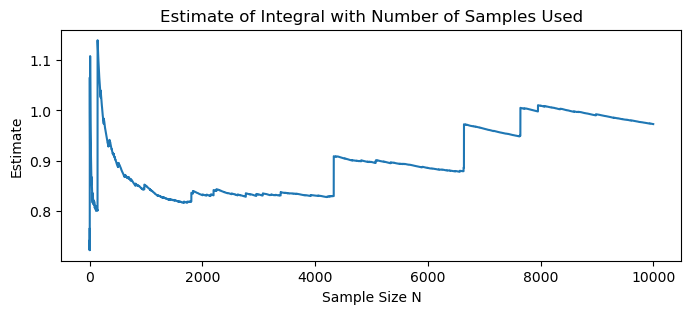

In [101]:
plt.figure(figsize = (8,3))
plt.plot(mu_n);
plt.xlabel("Sample Size N");
plt.ylabel("Estimate");
plt.title("Estimate of Integral with Number of Samples Used");

The estimate doesn't seem to converge nicely towards some asymptotic value as the number of samples used increases, but rather experiences weird abrupt jumps! This definitely suggests that something is going very wrong with our importance sampling procedure. Specifically, the sudden jumps suggests that, sometimes, we draw a sample that contributes an unusually huge amount to the estimate of the integral i.e. it has a huge weight. Let us examine the weights:

In [102]:
xplot = np.linspace(-6,6,10000)
qx_plot = q(xplot)
px_plot = p(xplot)
w_plot = px_plot/qx_plot

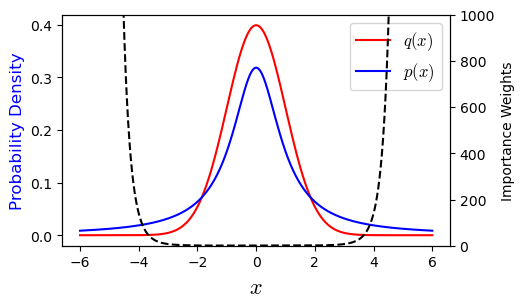

In [118]:
fig, ax1 = plt.subplots(figsize = (5,3))

ax1.plot(xplot,qx_plot, c = 'red', label = r"$q(x)$")
ax1.plot(xplot,px_plot, c = 'blue', label = r"$p(x)$")
ax1.set_xlabel(r"$x$", fontsize = 16)
ax1.set_ylabel("Probability Density", fontsize = 12, color = "blue")
plt.legend(fontsize = 12, loc = "upper right")
ax2 = ax1.twinx()
ax2.plot(xplot,w_plot, 'k--', label = r"$w(x)$")
ax2.set_ylabel('Importance Weights')
ax2.set_ylim(0,1000);

The importance weights increase exponentially away from the center! The estimate thus behaves erratically whenever we sample one those points that has huge weights (which has low probability but nonzero nonetheless). Formally, we can show that the second moment of the estimater is unbounded (or infinite), so that the entire estimation procedure is ill-defined. In layman terms, the Cauchy distribution has significantly fatter tails than the Gaussian, causing points in the tails to have huge weights; but at the same time those regions have non-negligible contributions to the integral so we cannot ignore them.

We <font color = "red">rarely</font> sample those regions, which makes our estimate <font color = "red">inaccurate</font>, and whenever we happen to sample from there, we get a <font color = "red">huge contribution</font> to our estimate, which <font color = "red">shifts</font> its value drastically. Unfortunately, your friend has suggested a <font color = "red"> poor importance function</font>, and should perhaps review their sampling methods notes.
<div style="text-align: right"><font size = "4">■</font></div>

<a name="problemtwo"></a><div class="alert alert-danger"><h3>Problem Two: Markov Chains</h3></div>

<div class="alert alert-success">
<b>Part (a) :</b> A Markov chain is typically characterized by a transition matrix (or transition kernel in the continuous case) $\mathcal{T}$, whose entries represent the probability of transitioning from one state to another. Consider the following Markov chain described by

$$
\mathcal{T} = \begin{bmatrix} \mathbb{P}\left(1 \rightarrow 1\right) &  \mathbb{P}\left(1 \rightarrow 2\right) & \mathbb{P}\left(1 \rightarrow 2\right)  \\ \mathbb{P}\left(2 \rightarrow 1\right) &  \mathbb{P}\left(2 \rightarrow 2\right) & \mathbb{P}\left(2 \rightarrow 2\right) \\
\mathbb{P}\left(3 \rightarrow 1\right) &  \mathbb{P}\left(3 \rightarrow 2\right) & \mathbb{P}\left(3 \rightarrow 2\right)
\end{bmatrix}
= \begin{bmatrix}
0 & 1/2 & 1/2 \\
1/4 & 1/2 & 1/4 \\
1/4 & 1/4 & 1/2
\end{bmatrix}
$$
</div>

<div class="alert alert-success">
    <b> Part (i) :</b> Sketch the associated transition diagram
</div>

<img src="Screenshot_1.png" width="500">
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
    <b> Part (ii) :</b> Find the stationary distribution $\pi$ of the chain. Recall that the stationary distribution satisfies the global balance condition $\pi = \pi \mathcal{T}$.
</div>

The global balance condition tells us that

$$\left[\pi_1 \,\, \pi_2 \,\, \pi_3 \right] =
\left[\pi_1 \,\, \pi_2 \,\, \pi_3 \right] \begin{bmatrix}
0 & 1/2 & 1/2 \\
1/4 & 1/2 & 1/4 \\
1/4 & 1/4 & 1/2
\end{bmatrix},
$$

which is a simple system of equations for three unknowns. We also note that

$$
\pi_1 + \pi_2 + \pi_3 = 1,
$$

i.e. the total probability of being somewhere needs to be one.

Solving this yields

$$\pi_1 = \frac{1}{5} \qquad \pi_2 =  \frac{2}{5} \qquad \pi_3 = \frac{2}{5}$$
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
    <b> Part (iii) :</b> Suppose that we start in state $1$ at $t = 0$. Plot how probability of being in each state changes with the number of timesteps $t$. Does it approach the stationary distribution $\pi$? 
</div>

Let $w^{(t)} = \left[w_1^{(t)}\,\,\,w_2^{(t)}\,\,\,w_3^{(t)}\right]$ be a row matrix representing the probability of being in each state at time $t$. At $t = 0$, we have $w^{(0)} = \left[1\,\,\,0\,\,\,0\right]$, since we start at state 1 without any ambiguity.

The probability of being in each state at the next timestep $t = 1$ is then simply

$$
w^{(1)} = w^{(0)} \mathcal{T} = \left[0\,\,\,1/2\,\,\,1/2\right].
$$

Repeating this $t$ times, we get

$$
w^{(t)} = w^{(0)} \mathcal{T}^{t}.
$$

This can be done in closed form (by spectral decomposition of $\mathcal{T}$, but for now, let us just numerically simulate it by multiplying matrices.

In [138]:
tmax = 30
T = np.array([[0,0.5,0.5],[0.25,0.5,0.25],[0.25,0.25,0.5]])    # Transition Matrix
w = np.zeros((tmax+1,3))    # Array to store the probabilities w(t)
w[0] = np.array([1,0,0])    # Starting state

In [139]:
for t in range(tmax):
    w[t+1] = w[t] @ T

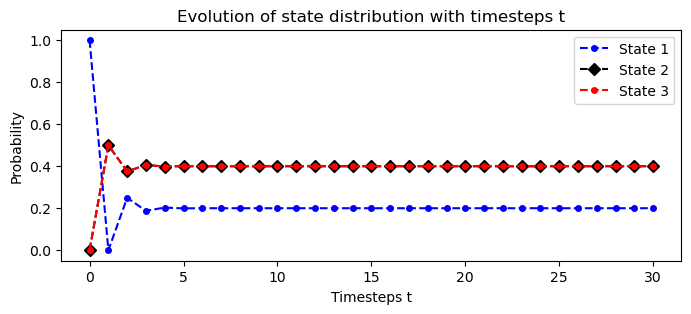

In [162]:
plt.figure(figsize = (8,3))
plt.plot(w[:,0], 'bo--', label = "State 1", markersize = 4);
plt.plot(w[:,1], 'kD--', label = "State 2");
plt.plot(w[:,2], 'ro--', label = "State 3", markersize = 4);
plt.xlabel("Timesteps t");
plt.ylabel("Probability");
plt.title("Evolution of state distribution with timesteps t");
plt.legend();

The probabilities do indeed converge rapidly towards the stationary distribution.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
    <b> Part (b) :</b> The Metropolis algorithm can be considered as a Markov chain in the parameter space of $\theta$. 
</div>

<div class="alert alert-info">
    <b> Part (i) :</b> What is the transition kernel $\mathcal{T}(\theta^{*}\,|\,\theta) = \mathbb{P}(\theta \rightarrow \theta^{*})$ in this case? Here, $\theta^{*}$ is the proposed move. Give your answer in terms of the target distribution $p$ (that we wish to sample from) and the proposal distribution $q$. 
</div>

The transition kernel $\mathcal{T}(\theta^{*}| \theta)$ depends on both:

1. The probability of proposing the move $\theta \rightarrow \theta^{*}$, which is given by the proposal distribution $q(\theta^{*}|\theta)$, and 

2. the probability of accepting the move, which is given by
$$
\alpha(\theta^{*}| \theta) = \mathrm{min}\left[\,1, \,\frac{p(\theta^{*})}{p(\theta)}\,\right].
$$

Putting these two pieces together, the transition kernel is hence simply

$$
\mathcal{T}(\theta^{*}| \theta) = q(\theta^{*}|\theta)\,\alpha(\theta^{*}| \theta).
$$
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
 <b> Part (ii) :</b>  Show that $\mathcal{T}(\theta^{*}\,|\,\theta)$ satisfies the detailed balance condition
    
$$p(\theta) \,\mathcal{T}(\theta^{*}\,|\, \theta) = p(\theta^{*}) \,\mathcal{T}(\theta\,|\, \theta^{*})$$
    
with respect to the target distribution $p(\theta)$. What is the physical interpretation of this condition? 
</div>

Let us start by considering the LHS of the detailed balance equation. We have

$$
p(\theta) \,\mathcal{T}(\theta^{*}| \theta) = p(\theta)\,q(\theta^{*}|\theta)\,\alpha(\theta^{*}| \theta) =  p(\theta)\,q(\theta^{*}|\theta)\,\cdot\mathrm{min}\left[\,1, \,\frac{p(\theta^{*})}{p(\theta)}\,\right].
$$

We now do a little trick: since multiplying two numbers by the same factor doesn't change the ordering of their sizes (i.e. if $a > b$, then $c a > c b$ for any positive number $c$, we can move $p(\theta)$ into the $\mathrm{min}$ function to get

$$
p(\theta) \,\mathcal{T}(\theta^{*}| \theta)  = q(\theta^{*}|\theta)\,\cdot\mathrm{min}\left[\,p(\theta), \,p(\theta^{*})\,\right].
$$

We do this trick one more time, this time multipling by $p(\theta^{*})$ outside the $\mathrm{min}$ function and dividing by $p(\theta^{*})$ inside the $\mathrm{min}$ function. This gives us

$$
p(\theta) \,\mathcal{T}(\theta^{*}| \theta)  = p(\theta^{*})\,q(\theta^{*}|\theta)\,\cdot\mathrm{min}\left[\,\frac{p(\theta)}{p(\theta^{*})}, \,1\,\right].
$$

Finally, we make use of the fact that our proposal kernel is <font color = "red">symmetric</font> i.e. $q(\theta^{*}|\theta) = q(\theta|\theta^{*})$, and recognise that

$$q(\theta|\theta^{*})\,\cdot\mathrm{min}\left[\,\frac{p(\theta)}{p(\theta^{*})}, \,1\,\right] = \mathcal{T}(\theta|\theta^{*})
$$
is just the transition kernel from $\theta^{*} \rightarrow \theta$ to arrive at

$$
p(\theta) \,\mathcal{T}(\theta^{*}\,|\, \theta) = p(\theta^{*}) \,\mathcal{T}(\theta\,|\, \theta^{*})
$$

Detailed balance implies that the rate of transition from $\theta$ to $\theta^{*}$ is the same as that from $\theta^{*}$ to $\theta$. The easiest way to visualize this is to think of $p(\theta)$ as describing a population and $\mathcal{T}(\theta^{*}|\theta)$ as the fraction of the population moving from $\theta$ to $\theta^{*}$. Then, $p(\theta)\, \mathcal{T}(\theta^{*}|\theta)$ is simply the number of people moving from $\theta$ to $\theta^{*}$. Detailed balance then means that the number of people moving from place A to place B is the same as that moving from place B to place A, so that the system is in dynamic equilibrium. 

<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
 <b> Part (iii) :</b>  Using the result of (ii), show that $p(\theta)$ is the stationary distribution of the Markov chain described by $\mathcal{T}(\theta^{*}\,|\,\theta)$. This completes the proof that the distribution of the samples generated by the Metropolis algorithm converges to $p(\theta)$.
</div>

We recall that the stationary distribution of a Markov chain satisfies the detailed balance condition $\pi = \pi \mathcal{T}$. If $p(\theta)$ is the stationary distribution of the Metropolis algorithm, then it needs to satisfy

$$
p(\theta) = \sum_{\theta^{*}} \, p(\theta^{*})\, \mathcal{T}(\theta\,|\,\theta^{*})
$$

Using the detailed balance condition, the RHS can be written as

$$
\sum_{\theta^{*}} \, p(\theta^{*})\, \mathcal{T}(\theta|\theta^{*}) = \sum_{\theta^{*}} \, p(\theta)\, \mathcal{T}(\theta^{*}\,|\,\theta) = p(\theta) \,\sum_{\theta^{*}}\, \mathcal{T}(\theta^{*}\,|\,\theta) 
$$

The sum is simply that total probability of going from $\theta$ to any other state, which must be one (it has to go somewhere!). Hence we get

$$
\sum_{\theta^{*}} \, p(\theta^{*})\, \mathcal{T}(\theta|\theta^{*}) =  p(\theta)
$$

which proves that $p(\theta)$ is the stationary distribution of the chain. This explains why and how the Metropolis algorithm works.
<div style="text-align: right"><font size = "4">■</font></div>

<a name="problemthree"></a><div class="alert alert-danger"><h3>Problem Three: Markov Chain Monte Carlo -- Basic Concepts</h3></div>

<div class="alert alert-success">
<b>Part (a) :</b> Briefly explain the differences between rejection sampling, importance sampling and MCMC sampling (the former two are sometimes collectively called simple Monte Carlo sampling). Explain when you might use one or the other.
</div>

Rejection sampling is the naive method of simply generating samples from a known distribution $q$ and then rejecting any excess density probabilistically in order to fit the target distribution $p$. The key advantages of rejection sampling are that (1) it is quick and easy to code and (2) the samples generated in this manner are guaranteed to be iid samples of the target distribution. However, (1) it can be difficult to find a good proposal that envelopes the target, and (2) it is very inefficient, as a sizeable portion of trials are discarded.

Importance sampling, on the other hand, is not a true sampling method: it does not actually generate samples from the target distribution. Rather, it is a technique for estimating integrals of some function $f$ taken wrt to the target distribution. It generates samples from an importance distribution $q$ and then weighs them appropriately. With a good importance distribution, this method can become extremely powerful, potentially being even more efficient than using samples from the original distribution. However, a poor importance distribution can lead to huge losses in efficiency and heavily biased weights, resulting in large sample variances.

Both rejection and importance sampling methods are highly susceptible to the <font color = "red">curse of dimensionality</font>, due to the difficulty of specifying proposal distributions that accurately sample the relevant regions with high probability mass, which form only a tiny fraction of the total parameter space.

MCMC aims to overcome this by (implicitly) constructing a Markov chain (model of transitioning between different points in parameter space) whose equilibrium distribution asymptotically approaches that of the target distribution. MCMC methods are very powerful in that very little information is required to be known about the target distribution in order to implement them successfully, and it minimizes the effect of the curse of dimensionality by being able to efficiently target and explore the typical set. In particular, Gibbs sampling circumvents it altogether by decomposing the problem of sampling from a N-dimensional distribution into that of sampling from a sequence of low-dimensional (possibly 1D) distributions. However, in MCMC, the samples drawn in this manner are correlated and are hence less informative than iid simulations. The approximation is also asymptotic and the distribution of the chain may take a significant time to converge, which means that many simulations may be required to fully explore the parameter space, a fact that might be ascerbated by a poor choice of hyperparameters.

<div class="alert alert-success">
<b>Part (b) :</b> Briefly explain the concepts of `burn-in', 'thinning' and  ‘effective sample size’ for MCMC.
</div>

'Burn-in' is a colloqial term that describes the practice of discarding the first $m$ iterations of a MCMC run, only using the subsequent iterations as samples for calculations. It is a rule-of-thumb stemming from the practical fact that we only have a finite set of samples, and hence want to avoid any transient behavior of the chain from biasing the results, rather that being a consequence of rigorous theory. Since we usually do not know the high density region beforehand, a poor choice of initialization may lead to early realizations of the chain not being representation of the target distribution. Note that some authors have criticized the concept of 'burn-in', arguing that it is a crude solution for selecting a poor starting sample.
	
The concept of 'effective sample size' arises because in most MCMC sampling approaches, samples that are drawn sequentially will be autocorrelated. Hence, the sequence of random variables generated will contain less information content about the underlying distribution as compared to a sequence of iid random variables of the same size. 'Effective sample size' attempts to capture this by asking: what would be the size of an equivalent iid sample that has the same variance as the existing sample? Mathematically, it is defined as

$$
N_{\mathrm{eff}} = \frac{N}{\sum_{t = -\infty}^\infty \rho_t} = \frac{N}{1 + 2\sum_{t = 1}^\infty \rho_t}, 
$$

where $\rho_t$ is the autocorrelation for time lag $t$.

'Thinning' is another method for dealing with the problem of autocorrelation. Instead of keeping all the samples, one might decide to keep only every $k$ samples. The idea is that since the samples taken in this manner are spaced apart, there will be very little correlation between them, and they can be effectively taken to be independent samples.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (c) :</b> Gibbs sampling is more efficient than the Metropolis algorithm. How does it achieve this extra efficiency? Are there any limitations to the Gibbs sampling strategy?
</div>

Some key advantages of the Gibbs sampler are that 
1. There is no need to tune the proposal distribution (it is an 'automatic' sampler)
2. Proposals are always accepted (no loss of efficiency from rejection)  
3. Conditional distributions are lower dimensional and easier to sample from (breaks the curse of dimensionality).

In particular, the Gibbs sampler is naturally suited for sampling from hierachical models, since the prior part of the posterior naturally factorizes into conditional distributions.
	
However, this requires that we are able to find the posterior conditionals for each of the variables as well as efficiently sample from them, which may not be possible. Furthermore, the Gibbs sampler tends to perform poorly if there is nontrivial correlation between the variables, since it cannot take 'diagonal steps' (recall that the Gibbs sampler sequentially updates each variable one-by-one in turn).
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (d) :</b> Gibbs sampling can be considered as a special case of the general Metropolis-Hastings algorithm. Show that when an appropriate proposal distribution $q(\theta^{*}|\theta)$ is used in the Metropolis-Hastings algorithm, it yields the same transition kernel $\mathcal{T}(\theta^{*}|\theta)$ as the one used in Gibbs sampling. (<i>Hint: Consider how moves are proposed in the Gibbs algorithm</i>)
</div>

Let $\mathbf{\theta} = (\theta_1, \theta_2,\ldots \theta_k)$ be a set of $k$ parameters specifiying the posterior, and we are interested in sampling from the posterior $p(\mathbf{\theta} \,|\, \mathcal{D})$, where $\mathcal{D}$ is some observed dataset. The Gibbs sampling procedure is then to iteratively sample from the conditional distributions:

\begin{align*}
\theta_{1}^{(n+1)} &\leftarrow \theta_1^{*} \sim p\left(\theta_1^{(n)} \,\bigr|\, \mathcal{D}, \theta_2^{(n)},\theta_3^{(n)}, \ldots \theta_k^{(n)}\right) \\
\theta_{2}^{(n+1)} &\leftarrow \theta_2^{*} \sim p \left(\theta_2^{(n)} \,\bigr|\, \mathcal{D}, \theta_1^{(n+1)},\theta_3^{(n)}, \ldots \theta_k^{(n)}\right) \\
\vdots\\
\theta_{k}^{(n+1)} &\leftarrow \theta_k^{*} \sim p\left(\theta_k^{(n)} \,\bigr|\, \mathcal{D}, \theta_1^{(n+1)},\theta_2^{(n+1)}, \ldots \theta_{k-1}^{(n+1)}\right)
\end{align*}

All the moves generated in this manner are automatically accepted; there is no acceptance-rejection procedure.

For notational convenience, let us define $\theta_{\overline{m}} = (\theta_1, \theta_2, \ldots \widehat{\theta}_m, \ldots \theta_k)$ as the set of all parameters excluding the $m$-th parameter. 

Since at each step, a new move is proposed only for a single $\theta_m$, the proposal distribution for the Gibbs sampler is of the form

$$
q(\theta^{*}|\theta) = p\left(\theta^{*}_m, \theta_{\overline{m}} \,|\, \theta_m, \theta_{\overline{m}}\right) 
$$

This can be simplified further by using the fact that the proposed value of $\theta_m$ only depends on the other parameters $\theta_{\overline{m}}$, so that

$$
q(\theta^{*}|\theta) = p\left(\theta^{*}_m, \theta_{\overline{m}} \,|\, \theta_m, \theta_{\overline{m}}\right) = p\left(\theta^{*}_m \,|\, \theta_{\overline{m}}\right), 
$$

Let us consider using this proposal distribution in a Metropolis-Hastings procedure. The Metropolis ratio is given by

$$
r = \frac{p(\theta^{*}) \,q(\theta|\theta^{*})}{p(\theta)\,q(\theta^{*}|\theta)} =
	\frac{p(\theta_m^{*}, \theta_{\overline{m}}^{*}) \,p\left(\theta_m \,|\, \theta_{\overline{m}}^{*}\right)}
	{p(\theta_m, \theta_{\overline{m}})\,p\left(\theta^{*}_m \,|\, \theta_{\overline{m}}\right)}
$$

Since all parameters other than $\theta_m$ are unchanged in the proposed move, we have $\theta_{\overline{m}}^{*} = \theta_{\overline{m}}$, so that

$$
\frac{p(\theta_m^{*}, \theta_{\overline{m}}^{*}) \,p\left(\theta_m \,|\, \theta_{\overline{m}}^{*}\right)}
{p(\theta_m, \theta_{\overline{m}})\,p\left(\theta^{*}_m \,|\, \theta_{\overline{m}}\right)}
= \frac{p(\theta_m^{*}, \theta_{\overline{m}}) \,p\left(\theta_m \,|\, \theta_{\overline{m}}\right)}
{p(\theta_m, \theta_{\overline{m}})\,p\left(\theta^{*}_m \,|\, \theta_{\overline{m}}\right)}
= \frac{p(\theta_m^{*} \,|\, \theta_{\overline{m}})\,p(\theta_{\overline{m}}) \,p\left(\theta_m \,|\, \theta_{\overline{m}}\right)}
	{p(\theta_m | \theta_{\overline{m}})\,p(\theta_{\overline{m}})\,p\left(\theta^{*}_m \,|\, \theta_{\overline{m}}\right)} = 1,
$$

Hence, the acceptance ratio is unity. This reproduces the Gibbs procedure.
	
Hence, we conclude that the Gibbs sampling procedure is simply a special case of the Metropolis-Hastings algorithm in which the proposal distribution is the _conditional distributions of the variables_.
<div style="text-align: right"><font size = "4">■</font></div>

<a name="problemfour"></a><div class="alert alert-danger"><h3>Problem Four: Metropolis Algorithm</h3></div>

<div class="alert alert-success">
<b>Part (a) :</b> Suppose that a random variable $X$ is distributed according to the PDF
    
$$p_X(x) = \frac{3}{8}\left(1+\frac{x^2}{4}\right)^{-5/2}, \quad x \in \mathbb{R},$$

which is the Student's $t$-distribution with parameter $\nu = 4$. 
</div>

<div class="alert alert-success">
<b>Part (i) :</b> Use the random walk Metropolis algorithm with proposal distribution $q(x^{*}|x) = \mathcal{N}(x,1)$, which is the typical standard normal centered around the current location, to draw samples from this distribution, making sure to choose an appropriate initialization, number of iteration steps and burn-in steps. Plot suitable histograms of the samples alongside the target PDF.
</div>

In [758]:
def p(x):
    # Target PDF
    return (3/8)*((1+x**2/4)**(-5/2))
    
def q(x1,x2):
    # Probability q(x2|x1) of proposing the move x1 -> x2
    return norm.pdf(x2, loc = x1, scale = 1)

def sample_q(x):
    # Draws a sample x' from q(x'|x)
    return norm.rvs(loc = x, scale = 1)

In [759]:
def metropolis_hastings(p, q, sample_q, param_init, num_samples):
    
    samples = np.zeros((num_samples, len(param_init)))
    samples[0] = param_init

    for n in range(num_samples-1):
    
        x_current = samples[n]
        x_proposed = sample_q(x_current)
        
        # Metropolis (acceptance) ratio
        r_num = q(x_proposed, x_current) * p(x_proposed)
        r_denom = q(x_current, x_proposed) * p(x_current)
        r = r_num / r_denom

        # Decide whether to accept the proposed move with probability min(1,r)
        if r >= 1:
            x_next = x_proposed
        elif uniform.rvs(0, 1) < r:
            x_next = x_proposed
        else:
            x_next = x_current
        
        samples[n+1] = x_next    # Store the new sample
    
    return samples

In [760]:
## Generate Samples using the Metropolis Algorithm
param_init = np.array([0]) 
num_samples = 5000
num_burn = 1000    # Number of samples at the start to discard (burn-in)
np.random.seed(13)
samples = metropolis_hastings(p,q, sample_q, param_init, num_samples)
samples = samples[num_burn:]

In [199]:
def num_bins(x):
    ## Selects number of histogram bins selected according to the Freedman–Diaconis rule
    N = len(x)
    bin_width = 2*iqr(x)/(N)**(1/3)
    n_bins = int((np.max(x) - np.min(x))/bin_width)
    return n_bins

In [761]:
import seaborn as sns
sns.set(style="darkgrid")

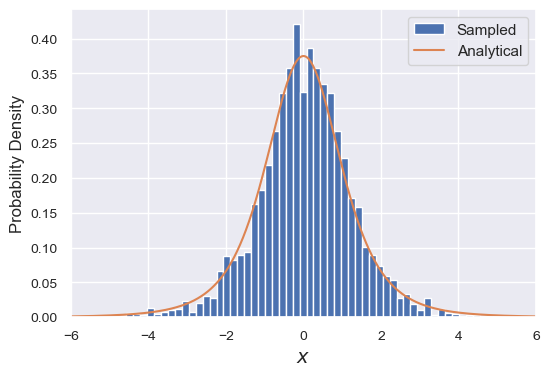

In [762]:
## Probability Density Plot
plt.figure(figsize = (6,4));

plt.hist(samples, bins = num_bins(samples), density = True, histtype = "bar", label = "Sampled");

x_plot = np.linspace(-6,6,10000)
pdf = p(x_plot)
plt.plot(x_plot, pdf, label = "Analytical")

plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.xlabel(r"$x$", fontsize = 14)
plt.ylabel("Probability Density", fontsize = 12)
plt.xlim(-6,6);
plt.legend(loc = 1);

<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (ii) :</b> Hence, calculate the mean $\mathbb{E}_p(x)$ of the distribution, along with any relevant error estimates.	
</div>

In [763]:
## Sample Mean
np.sum(samples)/len(samples)

0.039898926510023844

To estimate the error in our estimation of $\mathbb{E}_p(x)$, we need to calculate the <font color = 'red'>autocorrelation</font> of the chain, which will in turn allow us to calculate the <font color = 'red'>effective sample size</font>, and then finally the standard error.

In [779]:
rho = acf(samples[:,0], nlags = 100)    # Autocorrelation of the chain from t = 0 to t = 100
rho = rho[:np.argmax(rho<0)]    # Truncate at first negative

rho here is an array whose elements represent the autocorrelation at different time lags. Note that there are many subtleties related to estimating the autocorrelation time; if that is of interest to you, you can check out resources online in your own time. The basic idea though is that we should truncate it from a numerical standpoint - as we go further out, there is more noise than signal.

We can then calculate the effective sample size via

$$
N_{\mathrm{eff}} = \frac{N}{\sum_{k = -\infty}^{\infty} \rho_k} = \frac{N}{1 + 2 \sum_{k = 1}^{\infty} \rho_k}  = \frac{N}{2 \sum_{k = 0}^{\infty} \rho_k - 1}
$$

In [780]:
N_eff = len(samples)/(2*np.sum(rho)-1)    # Effective sample size
print(N_eff)

215.72074054395168


Finally, the Monte Carlo Standard Error (MCSE) is simply the standard deviation of the samples divided by the square root of the effective sample size i.e. replacing $N$ in the usual standard error definition with $N_\mathrm{eff}$.

In [781]:
mcse = np.std(samples)/np.sqrt(N_eff)    # Monte Carlo Standard Error
print(mcse)

0.08167622955205993


Our Monte Carlo estimate of $\mathbb{E}_p(x)$ is hence

$$
\hat{\mu} = 0.04 \pm 0.08,
$$

which seems reasonable compared to the true value of $\mu = 0$. Note: one might be tempted to say that the "error is larger than the estimate", which is a common trap. This is simply because the true value is very small: if the true mean turned out to be say 5, then our estimate would be something like $5.05 \pm 0.08$, showing that this is simply an illusion.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
<b>Part (b) :</b> Consider the 2D PDF
	
$$
p(x,y) \propto \tilde{p}(x,y) = \exp\left[-\frac{0.8 x^2 + (y - \sqrt[3]{x^2})^2}{4}\right].
$$

The tilde is a common notation for indicating that a quantity is unnormalized.
</div>

<div class="alert alert-info">
<b>Part (i) :</b> Use the random walk Metropolis algorithm with proposal distribution $q(x^{*}|x) = \mathcal{N}(x,\sigma^2)$ with an appropriate choice of $\sigma^2$ to draw samples from this distribution, and hence calculate the expectation values $\mathbb{E}_p[x]$ and $\mathbb{E}_p[y]$ . You should plot any suitable diagnostic tools (e.g. histograms of the samples and trace plots).
</div>

In [782]:
def p(x):
    # Target PDF
    u = 0.8*(x[0]**2) + (x[1] - (x[0]**2)**(1/3))**2
    return np.exp(-u/4)
    
def q(x1,x2):
    # Probability q(x2|x1) of proposing the move x1 -> x2
    return multivariate_normal.pdf(x2, mean = x1, cov = 1)

def sample_q(x):
    # Draws a sample x' from q(x'|x)
    return multivariate_normal.rvs(mean = x, cov = 1)

In [783]:
## Generate Samples using the Metropolis Algorithm
param_init = np.array([0,0]) 
num_samples = 10000
num_burn = 1000    # Number of samples at the start to discard (burn-in)
np.random.seed(527)
samples = metropolis_hastings(p,q, sample_q, param_init, num_samples)
samples = samples[num_burn:]

In [784]:
x_samples = samples[:,0]
y_samples = samples[:,1]

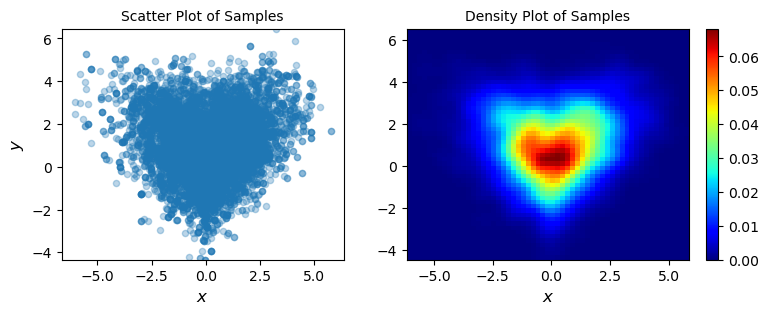

In [786]:
mpl.rc_file_defaults()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,3), gridspec_kw={'width_ratios': [4, 5]})

## Scatter Plot of Samples
ax1.scatter(x_samples,y_samples,alpha=0.3, s = 20)
ax1.set_xlabel(r'$x$', fontsize = 12);
ax1.set_ylabel(r'$y$', fontsize = 12);
ax1.set_title("Scatter Plot of Samples", fontsize = 10)
ax1.set_ylim(y_samples.min(),y_samples.max())

## Density Plot of Samples
# Calculate optimal number of bins
nbins_x = num_bins(x_samples)
nbins_y = num_bins(y_samples)
# Coordinate Grid for 2D Density Plot
xi, yi = np.mgrid[x_samples.min():x_samples.max():nbins_x*1j, y_samples.min():y_samples.max():nbins_y*1j]  
# Kernel Density Estimate from Samples
k = gaussian_kde([x_samples, y_samples])
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cbar =ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap = 'jet');
plt.colorbar(cbar, ax = ax2);
ax2.set_title("Density Plot of Samples", fontsize = 10);
ax2.set_xlabel(r'$x$', fontsize = 12);

In [800]:
def MCMC_stats(x):
    mean = np.mean(x)
    rho = acf(x, nlags = 100)   
    rho = rho[:np.argmax(rho<0)]  
    N_eff = len(x)/(2*np.sum(rho)-1)    
    mcse = np.std(x)/np.sqrt(N_eff) 
    print("ESS: ", N_eff)
    print("Mean: ", mean)
    print("MCSE: ", mcse)

In [803]:
print("Expectation value of x")
MCMC_stats(x_samples)

Expectation value of x
ESS:  448.6389210626192
Mean:  0.08064070096914162
MCSE:  0.07751697975744333


In [804]:
print("Expectation value of y")
MCMC_stats(y_samples)

Expectation value of y
ESS:  493.1546289495483
Mean:  1.020775913060573
MCSE:  0.06817887137229924


<div class="alert alert-info">
<b>Part (ii) : (Bonus) </b> Consider now a slight modification of the proposal distribution that tries to take into account the shape of the target distribution. Instead of using a Gaussian centered around the current location, we \emph{shift} the center of the Gaussian to

$$
x \rightarrow  g(x) =  x + \frac{\sigma^2}{2} \frac{\tilde{p}'(x)}{\tilde{p}(x)}, \quad \mathrm{where} \quad
\tilde{p}'(x) = \frac{\mathrm{d}\tilde{p}(x)}{\mathrm{d}x},
$$

giving us the modified proposal distribution $q_g(x^{*}|x) = \mathcal{N}(g(x),\sigma^2)$. This is the simplest example of a so-called <i>gradient method</i>. Repeat (i) using this proposal distribution and compare their performance.  
</div>

In [805]:
def q_lang(x1,x2):
    # Probability q(x2|x1) of proposing the move x1 -> x2
    xshifted = x1 + (1/2)*optimize.approx_fprime(x1,p)/p(x1) 
    return multivariate_normal.pdf(x2, mean = xshifted, cov = 1)

def sample_q_lang(x):
    # Draws a sample x' from q(x'|x)
    xshifted = x + (1/2)*optimize.approx_fprime(x,p)/p(x) 
    return multivariate_normal.rvs(mean = xshifted, cov = 1)

In [806]:
param_init = np.array([0,0])
num_samples = 10000
num_burn = 1000    # Number of samples at the start to discard (burn-in)
np.random.seed(91)
samples = metropolis_hastings(p,q_lang, sample_q_lang, param_init, num_samples)
samples = samples[num_burn:]

In [807]:
x_samples = samples[:,0]
y_samples = samples[:,1]

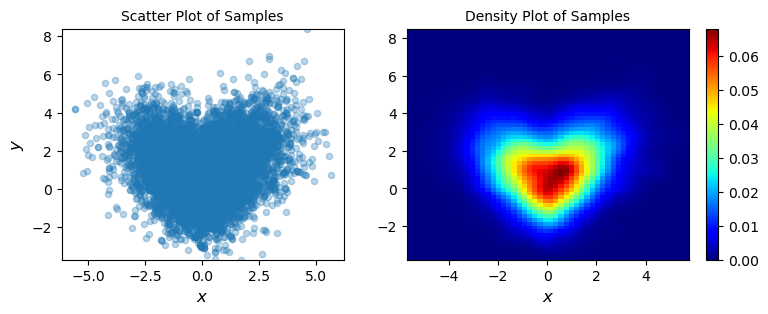

In [808]:
mpl.rc_file_defaults()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,3), gridspec_kw={'width_ratios': [4, 5]})

## Scatter Plot of Samples
ax1.scatter(x_samples,y_samples,alpha=0.3, s = 20)
ax1.set_xlabel(r'$x$', fontsize = 12);
ax1.set_ylabel(r'$y$', fontsize = 12);
ax1.set_title("Scatter Plot of Samples", fontsize = 10)
ax1.set_ylim(y_samples.min(),y_samples.max())

## Density Plot of Samples
# Calculate optimal number of bins
nbins_x = num_bins(x_samples)
nbins_y = num_bins(y_samples)
# Coordinate Grid for 2D Density Plot
xi, yi = np.mgrid[x_samples.min():x_samples.max():nbins_x*1j, y_samples.min():y_samples.max():nbins_y*1j]  
# Kernel Density Estimate from Samples
k = gaussian_kde([x_samples, y_samples])
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cbar =ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap = 'jet');
plt.colorbar(cbar, ax = ax2);
ax2.set_title("Density Plot of Samples", fontsize = 10);
ax2.set_xlabel(r'$x$', fontsize = 12);

In [809]:
print("Expectation value of x")
MCMC_stats(x_samples)

Expectation value of x
ESS:  705.0555598709591
Mean:  0.09384126773857536
MCSE:  0.05925001513955472


In [810]:
print("Expectation value of y")
MCMC_stats(y_samples)

Expectation value of y
ESS:  773.0260250074388
Mean:  1.0931510871660504
MCSE:  0.05500189693923643


|   | Metropolis    | Langevin-Metropolis | True Value |
|---|---------------|---------------------|------------|
| x | 0.081 ± 0.078 | 0.094 ± 0.059       | 0          |
| y | 1.020 ± 0.068 | 1.093 ± 0.055       | 1.089      |

Both methods are somewhat off when it comes to $\mathbb{E}[x]$ but the Langevin method is noticeably better when it comes to $\mathbb{E}[y]$. It also has a higher effective sample size.

<a name="problemfive"></a><div class="alert alert-danger"><h3>Problem Five: Gibbs Sampling</h3></div>

<div class="alert alert-success">
<b>Part (a) :</b> Suppose we want to sample from the bivariate distribution
	
$$
p(x,y) \propto \exp\left[-x^2 -(y-x^2)^2\right] \quad x,y \in \mathbb{R}.
$$
</div>

<div class="alert alert-success">
<b>Part (i) :</b> What is the conditional distribution $p(y|x)$? In particular, what family does it belong to?
</div>

The conditional distribution is given by

$$
p(y|x) = \frac{p(x,y)}{p_{x}(x)},
$$

where $p_{x}(x)$ is the marginal density of $x$, which can be evaluated as

$$
p_{x}(x) = \int_{-\infty}^{\infty} p(x,y)\,\mathrm{d}y = \int_{-\infty}^{\infty} \exp\left[-x^2 -(y-x^2)^2\right]\,\mathrm{d}y = \sqrt{\pi} \exp[-x^2].
$$

Hence, we get

$$
p(y|x) = \frac{\exp\left[-x^2 -(y-x^2)^2\right]}{\sqrt{\pi} \exp[-x^2]} = \frac{1}{\sqrt{\pi}} \exp\left[-(y-x^2)^2\right],
$$

which is a Gaussian distribution with mean $x^2$ and $\sigma = 1/\sqrt{2}$ i.e. $\mathcal{N}\left(x^2, 1/2\right)$.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (ii) :</b> 
Write down the conditional distribution $p(x|y)$. That is not a standard distribution. If you were to sample from this by	rejection sampling, write down the proposal distribution and acceptance probability.
</div>

The conditional distribution is given by

$$
p(x|y) = \frac{p(x,y)}{p_{y}(y)} = \frac{\exp\left[-x^2 -(y-x^2)^2\right]}{\int_{-\infty}^{\infty} \exp\left[-x^2 -(y-x^2)^2\right]\,\mathrm{d}x}.
$$

While it is possible, in theory, to perform the integral analytically, the form is exceedingly unwieldy and involves non-elementary functions (modified Bessel functions), with the exact analytical form depending on the value of $y$ as well. Fortunately for us, given a particular value of $y$, this is simply a constant and we can focus on the functional form of the numerator for generating samples of $x$.

To sample from this distribution, we would hence need to sample from $\exp\left[-x^2 - (y-x^2)^2\right]$. Wait a minute, you might say, isn't that just the same distribution we wanted to sample from in the first place! Did we just go in a big circle? But, wait, this is not a 2D distribution, because in this scenario, $y$ is a constant, and we are only sampling $x$!

Now, therefore this suggests that we can perform rejecting sampling using $Mq(x) = \exp\left[-x^2\right]$ as our proposal distribution (convince yourself that this is always greater than $\exp\left[-x^2 - (y-x^2)^2\right]$). The acceptance probability would be $r = \exp\left[- (y-x^2)^2\right]$.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (iii) :</b> Describe the overall Gibbs sampling algorithm briefly.
</div>

1. Start by choosing a good initialization point. In this case, the origin $(x_0, y_0) = (0,0)$ is the natural choice since it is the mode of the target distribution.

2. Sample $x_1$ from $p(x|y_0)$. In this case we would use our rejection sampling routine described above to sample from $\exp[-x^2-(y_{0}-x^2)^2]$.

3. Sample $y_{1}$ from $p(y|x_{1})$. In this case, it would be a Gaussian $\mathcal{N}((x_{1})^2, 1/\sqrt{2})$.

4. Repeat this iteratively until the desired number of samples are obtained.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (iv) :</b> Implement the Gibbs sampling algorithm and use it to calculate the mean of $y$.
</div>

In [819]:
## Define Procedures for drawing samples from the conditional distributions

def sample_y(x):
    """Samples from p(y|x)"""
    return norm.rvs(loc = x**2, scale = 1/np.sqrt(2))

def sample_x(y):
    """Samples from p(x|y). To do so, we will use rejection sampling"""
    def p(x,y):
        """Target distribution p(x|y)"""
        return np.exp(-x**2 - (y-x**2)**2)
    def q(x,y):
        """Proposal distribution M q(x|y). Here, M = sqrt(pi)"""
        return np.sqrt(np.pi)*norm.pdf(x,loc = 0, scale = 1/np.sqrt(2))
    
    def sample_q(y):
        """Draws sample x from q(x|y)"""
        return norm.rvs(loc = 0, scale = 1/np.sqrt(2))
    
    # Accept-Reject Algorithm
    accept = False
    while accept == False:
        x_new = sample_q(y)
        r = p(x_new,y) / q(x_new,y)    # Acceptance ratio        
        
        if r > 1:
            # Stop algorithm if acceptance ratio exceeds one
            print("ERROR: Acceptance ratio is greater than one at (x,y) = (" + str(x_new) + "," + str(y) + ")")
            break;

        if uniform.rvs(0, 1) < r:
            # If new point is accepted, return it, otherwise try drawing a new sample
            accept = True
            return x_new

In [820]:
def gibbs_sampler_2D(sample_x, sample_y, param_init, num_samples):
    """Routine for generating samples using the Gibbs algorithm for a 2D pdf"""
    samples = np.zeros((num_samples, len(param_init)))
    samples[0] = param_init
    
    for n in range(num_samples-1):
        samples[n+1][0] = sample_x(samples[n][1])    # Update x
        samples[n+1][1] = sample_y(samples[n+1][0])    # Update y
    
    return samples

In [821]:
## Generate Samples from the Gibbs Algorithm
param_init = np.array([0,0]) 
num_samples = 10000
num_burn = 1000
np.random.seed(4106)
samples = gibbs_sampler_2D(sample_x,sample_y,param_init, num_samples)

In [822]:
x_samples = samples[:,0]
y_samples = samples[:,1]

#### Visualization of Samples

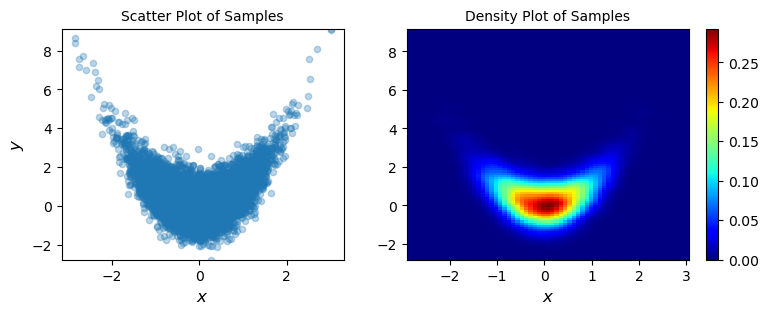

In [823]:
mpl.rc_file_defaults()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,3), gridspec_kw={'width_ratios': [4, 5]})

## Scatter Plot of Samples
ax1.scatter(x_samples,y_samples,alpha=0.3, s = 20)
ax1.set_xlabel(r'$x$', fontsize = 12);
ax1.set_ylabel(r'$y$', fontsize = 12);
ax1.set_title("Scatter Plot of Samples", fontsize = 10)
ax1.set_ylim(y_samples.min(),y_samples.max())

## Density Plot of Samples
# Calculate optimal number of bins
nbins_x = num_bins(x_samples)
nbins_y = num_bins(y_samples)
# Coordinate Grid for 2D Density Plot
xi, yi = np.mgrid[x_samples.min():x_samples.max():nbins_x*1j, y_samples.min():y_samples.max():nbins_y*1j]  
# Kernel Density Estimate from Samples
k = gaussian_kde([x_samples, y_samples])
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cbar =ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap = 'jet');
plt.colorbar(cbar, ax = ax2);
ax2.set_title("Density Plot of Samples", fontsize = 10);
ax2.set_xlabel(r'$x$', fontsize = 12);

#### Estimation of expectation values E[x] and E[y]

In [824]:
print("Expectation of x"); print("-----------------")
MCMC_stats(x_samples)
print("Expectation of y");  print("-----------------")
MCMC_stats(y_samples)

Expectation of x
-----------------
ESS:  10000.0
Mean:  -0.0019027721014299218
MCSE:  0.0070127498990020035
Expectation of y
-----------------
ESS:  2045.334233652793
Mean:  0.5027482910054759
MCSE:  0.021987315135874586


This is fairly close to the true values of $\mathbb{E}[x] = 0$ and $\mathbb{E}[y] = 0.5$.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
<b>Part (b) :</b> Let us now study a simple example of Bayesian inference using Gibbs sampling techniques. Suppose that we have $N$ observations $x^{N} \equiv \{x_1, x_2, \ldots x_N\}$ that we hypothesize are generated by a truncated exponential
    
$$
x \sim p(x|\alpha,\beta) = \alpha \beta \,e^{-\alpha \beta x}\quad ,\quad x > 0
$$

where $\alpha$ and $\beta$ are unknown. Our task then is to attempt to infer the values of $\alpha$ and $\beta$ based on the observations.
</div>

<div class="alert alert-info">
<b>Part (i) :</b> Generate $N = 10$ `observations' $x^{N} \equiv \{x_1, x_2, \ldots x_N\}$ from the model with the parameters $\alpha = 2$ and $\beta = 5$. This will serve as our dummy dataset. Pretend that these came from some experiment and forget about the true values of $\alpha$ and $\beta$.
</div>

In [825]:
x_obs = np.random.exponential(scale = 1/(2*5), size  = 10)

<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
<b>Part (ii) : </b>Let us choose

$$
p(\alpha,\beta) = e^{-(\alpha + \beta)}\quad,\quad \alpha,\beta > 0
$$
    
as our prior. Write down the posterior $p(\alpha,\beta\,|\,x^{N})$
</div>

The likelihood is

$$
p(x^N|\alpha,\beta) = \prod_i^N p(x_i | \alpha, \beta) = \prod_i^N \alpha \beta \,e^{-\alpha \beta x_i}
= (\alpha \beta )^N \exp\left[- \alpha \beta \sum_i^N x_i\right],
$$

and the posterior is thus

$$
p(x^N|\alpha,\beta) \propto p(x^N|\alpha,\beta) \, p(\alpha,\beta) = (\alpha \beta )^N \exp\left[- \alpha - \beta - \alpha \beta \sum_i^N x_i\right]\quad,\quad \alpha, \beta >0
$$
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
<b>Part (iii) </b> Derive the conditional distributions $p(\alpha\, |\, \beta, x^{N})$ and  $p(\beta\, | \,\alpha, x^{N})$
</div>

Since we are only interested in what the conditional distributions are proportional to, we only need to focus on the parts that contain the variable of interest (the other variables, by definition, are <font color = 'red'>constant</font>). Hence we have

$$
p(\alpha\,|\,\beta, x^{N}) \propto \alpha^{N}\,\exp\left[-\alpha(1+N\beta \bar{x})\right],
$$

where $\bar{x} = \sum_i x_i / N $ is the mean of the observations. If we look hard enough, this is the gamma $\Gamma(N+1, 1+N\beta \bar{x})$ distribution! It is usually a good practice to have a reference of common distributions to refer to.

By symmetry, $p(\beta\,|\,\alpha, x^{N})$ will be proportional to $\Gamma(N+1, 1+N\alpha \bar{x})$.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-info">
<b>Part (iv) : </b>  Use Gibbs sampling to draw $5000$ samples from the posterior density. Plot the drawn samples with x-axis $\alpha$ and y-axis $\beta$ and report the posterior mean of $\alpha$ and $\beta$.
</div>

In [829]:
## Define Procedures for drawing samples from the conditional distributions
n_obs = 10
mean_obs = np.mean(x_obs)

def sample_y(x):
    """Samples from p(y|x)"""
    a = n_obs + 1
    b = 1 + n_obs*mean_obs*x
    return gamma.rvs(a = a, scale = 1/b)

def sample_x(y):
    """Samples from p(x|y)"""
    a = n_obs + 1
    b = 1 + n_obs*mean_obs*y
    return gamma.rvs(a = a, scale = 1/b)

In [830]:
## Generate Samples from the Gibbs Algorithm
param_init = np.array([0.25,0.25]) 
num_samples = 5000
num_burn = 1000
np.random.seed(1617)
samples = gibbs_sampler_2D(sample_x,sample_y,param_init, num_samples)

In [831]:
x_samples = samples[:,0]
y_samples = samples[:,1]

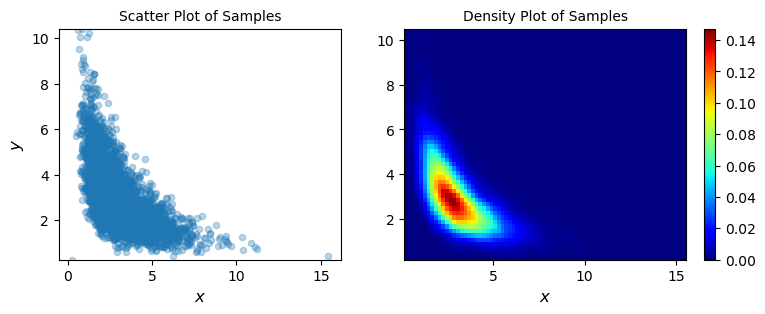

In [832]:
mpl.rc_file_defaults()
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9,3), gridspec_kw={'width_ratios': [4, 5]})

## Scatter Plot of Samples
ax1.scatter(x_samples,y_samples,alpha=0.3, s = 20)
ax1.set_xlabel(r'$x$', fontsize = 12);
ax1.set_ylabel(r'$y$', fontsize = 12);
ax1.set_title("Scatter Plot of Samples", fontsize = 10)
ax1.set_ylim(y_samples.min(),y_samples.max())

## Density Plot of Samples
# Calculate optimal number of bins
nbins_x = num_bins(x_samples)
nbins_y = num_bins(y_samples)
# Coordinate Grid for 2D Density Plot
xi, yi = np.mgrid[x_samples.min():x_samples.max():nbins_x*1j, y_samples.min():y_samples.max():nbins_y*1j]  
# Kernel Density Estimate from Samples
k = gaussian_kde([x_samples, y_samples])
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
cbar =ax2.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap = 'jet');
plt.colorbar(cbar, ax = ax2);
ax2.set_title("Density Plot of Samples", fontsize = 10);
ax2.set_xlabel(r'$x$', fontsize = 12);

In [834]:
print("Expectation of alpha"); print("-----------------")
MCMC_stats(x_samples)
print("Expectation of beta");  print("-----------------")
MCMC_stats(y_samples)

Expectation of alpha
-----------------
ESS:  1670.9804016596925
Mean:  3.047727313988593
MCSE:  0.03336748076821246
Expectation of beta
-----------------
ESS:  1701.1497994944182
Mean:  2.9920673172848296
MCSE:  0.031779047852613054


These values don't quite seem to agree with the values that we put in. If we think about it, however, the original model only depended on the product $\alpha \beta$, i.e. $\alpha = 2, \beta = 5$ and $\alpha = 4, \beta = 2.5$ would give the same model. Hence, any sort of imbalance between the two can only come about in the prior. However, the prior that we chose was independent and symmetric, and therefore that is the result that we recover. This exercise demonstrates that when variables are coupled together, it can be hard to discern them unless we have a biased prior to inform us (this shows up a lot in mixture models too).
<div style="text-align: right"><font size = "4">■</font></div>

<a name="problemsix"></a><div class="alert alert-danger"><h3>Problem Six: Inverse Transform Sampling</h3></div>

<div class="alert alert-success">
<b>Part (a) :</b> For a continuous random variable $X$ with cumulative density function (CDF) $F_X$, show that the random variable $Y = F_X(x)$ is uniformly distributed on the interval $[0, 1]$. (<i>Hint: consider the CDF of $Y$</i>).
</div>

As suggested by the hint, we consider the cdf $F_y$ of $y$, $F_y(\beta) = \mathbb{P}(y \leq \beta)$. Since $F_x(x)$ is a CDF, it maps $x$ to the interval $[0,1]$. It follows that $y = F_x(x)$ necessarily lies in the interval $[0,1]$, and hence that $F_y(\beta) = 0$ for $\beta < 0$ and $F_y(\beta) = 1$ for $\beta >1$.

We next consider $\beta \in [0,1]$. Let $\alpha$ be the value of $x$ that $F_x$ maps to $\beta$, i.e. $F_x(\alpha) = \beta$, or equivalently, $\alpha = F_x^{-1}(\beta)$. We can write the CDF of $y$ as

$$
F_y(\beta) = \mathbb{P}(y \leq \beta) = \mathbb{P}(F_x(\alpha) \leq \beta) = \mathbb{P}(x \leq F_x^{-1}(\beta)) = \mathbb{P}(x \leq \alpha) = F_x(\alpha) = \beta,   
$$

where we have used the fact that $F_x$ is a non-decreasing function.
	
Putting everything together, we find that the CDF of $y$ is given by

\begin{align*}
F_y(\beta) = \begin{cases} 0, & \beta < 0 \\ \beta, & 0 \leq \beta \leq 1 \\ 1, & \beta > 1 \end{cases}
\end{align*}

This is none other than the cdf of a uniform random variable on $[0,1]$. Thus, we conclude that $y = F_x(x)$ is indeed uniformly distributed on $[0, 1]$. 
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (b) :</b> Explain how the result of (a) can be used to draw samples from a desired pdf $p_X(x)$, starting only from a uniform random generator.
</div>

In (a), we started with a random variable $x$ with cdf $F_x$ and, after performing a transformation $y = F_x(x)$, ended up with a uniformly distributed random variable $y \sim \mathcal{U}(0,1)$. It stands to reason then that we can simply <font color = 'red'>invert</font> the process: we start instead with a uniformly distributed random variable $y$, and perform the <font color = 'red'>inverse transformation</font> $x = F_x^{-1}(y)$ in order to obtain a random variable $x$ that has the desired cdf $F_x$. 
	
Assuming that we can invert the target cdf $F_x$ (either analytically or numerically), the so-called <font color = 'red'>inverse transform sampling</font> method consists of:

1. Calculating the inverse of the target CDF $F_x^{-1}$
2. Sampling iid random variables from a uniform distribution $y_{i} \sim \mathcal{U}(0,1)$
3. Transforming each sample by $x_{i} = F_x^{-1}(y_{i})$ 

The $\{x_{i}\}$ obtained in this manner will be iid samples satisfying the target CDF $F_x$.
<div style="text-align: right"><font size = "4">■</font></div>

<div class="alert alert-success">
<b>Part (c) :</b> The Laplace distribution with zero mean and unit variance has PDF

$$
p_X(x) = \frac{1}{\sqrt{2}} \exp\left[-\sqrt{2} \left|x\right|\right] \quad x \in \mathbb{R}.
$$

You might recall that we encountered this function (with a slightly different variance) earlier in Problem 1. Use inverse transform sampling to generate $N$ iid samples from $p_X(x)$. You should derive the necessary transformations and implement a numerical routine. Plot suitable histograms of the samples alongside the (analytical) target distribution.
</div>

As established in the earlier parts, we need to calculate the CDF $F_x(\alpha)$ of the random variable $x$ as well as its inverse. The CDF of $x$ is given by

$$
F_x(\alpha) = \int_{-\infty}^{\alpha} p_x(x) \,\mathrm{d}x = \int_{-\infty}^{\alpha} \frac{1}{\sqrt{2}} \exp\left[-\sqrt{2} \left|x\right|\right] \,\mathrm{d}x =
\begin{cases} \frac{1}{2} \exp\left[\sqrt{2} \alpha\right], & \alpha \leq 0 \\ 1 - \frac{1}{2} \exp\left[-\sqrt{2} \alpha\right], & \alpha > 0.\end{cases}
$$

The inverse of this CDF can be calculated to be

$$
F_x^{-1}(y) = - \frac{1}{\sqrt{2}}\,\mathrm{sgn}\,\left(y-\frac{1}{2}\right) \log\left[\,1 - 2 \,\left|\,y-\frac{1}{2}\,\right|\,\right],
$$

where the mathematical details are left as an exercise to the reader. 

In [176]:
def p(x):
    # Target PDF
    return (1/np.sqrt(2))*np.exp(-np.sqrt(2)*np.abs(x))

def inversecdf(y):
    # Inverse of CDF of x
    return (1/np.sqrt(2))*np.sign(y-0.5)*np.log(1 - 2*np.abs(y-0.5)) 

In [164]:
## Perform the sampling and transform
N = 10000    
np.random.seed(137)
y = np.random.uniform(0,1,N)    # Draw N samples from U(0,1)
x = inversecdf(y)    # Inverse CDF transform

In [168]:
## Setup histogram plotting parameters
bin_width = 2*iqr(x)/(N)**(1/3)    # Bin width selected according to the Freedman–Diaconis rule
n_bins = int((np.max(x) - np.min(x))/bin_width)

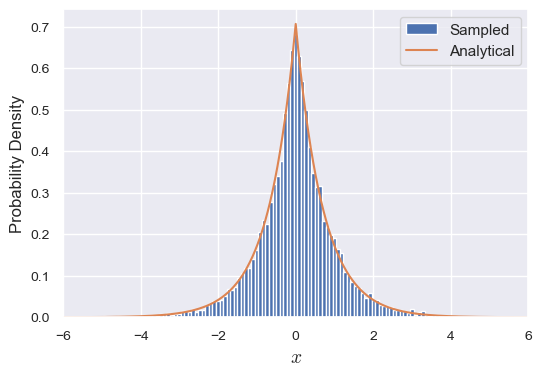

In [179]:
## Probability Density Plot
plt.figure(figsize = (6,4));

plt.hist(x, bins = n_bins, density = True, histtype = "bar", label = "Sampled");

x_plot = np.linspace(-6,6,10000)
pdf = p(x_plot)
plt.plot(x_plot, pdf, label = "Analytical")

plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.xlabel(r"$x$", fontsize = 14)
plt.ylabel("Probability Density", fontsize = 12)
plt.xlim(-6,6);
plt.legend(loc = 1);

<div style="text-align: right"><font size = "4">■</font></div>